# 1 Web Mining

In [1]:
from pandas import DataFrame
from time import sleep
from datetime import datetime
from random import uniform, choice
from requests import get
from bs4 import BeautifulSoup

!python --version # 3.10.11

Python 3.10.11


In [2]:
now = datetime.now().isoformat(sep='_')
now = now.split('.')[0].split(':')[:2]
now = 'h'.join(now).replace('-', '_')
now

'2023_08_06_23h23'

In [3]:
url_root = 'https://g1.globo.com/'

user_agents = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36'
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36'
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15'
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 13_1) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15'
]

As definições do G1 não permitem fazer scraping/crawling na página de "busca", conforme mostrado em seu arquivo `robots.txt`:

In [4]:
url_robots = url_root + 'robots.txt'
resp_robots = get(url_robots).content
soup_robots = BeautifulSoup(resp_robots, 'html.parser')
print(soup_robots)

User-Agent: *
Disallow: /jornalismo/g1/
Disallow: /_ssi/
Disallow: /teste-*.html$
Disallow: /beta/
Disallow: /componentes/
Disallow: /busca/*
Disallow: /globo-news/jornal-globo-news/videos/v/globo-news-ao-vivo/61910/
Disallow: /globonews/playlist/globonews-ao-vivo.ghtml
Disallow: *globo-cdn-src/*
Disallow: /zeta/
Sitemap: https://g1.globo.com/sitemap/g1/sitemap.xml
Sitemap: https://g1.globo.com/sitemap/Apuração/g1/sitemap.xml




Por isso será utilizada a página "tudo-sobre" do G1 dedicada ao Twitter.

## 1.1 Web Crawling

Obtendo uma lista de links de notícias sobre o Twitter:

In [5]:
url_base = url_root + 'tudo-sobre/twitter/'
n_feed_pages = 100
links = []
for i in range(n_feed_pages):
    url = url_base + f'index/feed/pagina-{i+1}.ghtml'
    sleep(uniform(1, 3))
    dict_headers = {'User-Agent': choice(user_agents)}
    resp = get(url, headers=dict_headers).content
    soup = BeautifulSoup(resp, 'html.parser')
    link_class = 'feed-post-link'
    soup_links = soup.find_all('a', class_=link_class, href=True)
    for a in soup_links:
        link = a.get('href')
        if 'twitter' in link and 'noticia' in link:
            links.append(link)
            print(link)
            print('-'*80)
print('TOTAL:', len(links))
print('TOTAL (distintos):', len(set(links)))

https://g1.globo.com/tecnologia/noticia/2023/07/31/x-gigante-e-retirado-do-topo-do-predio-do-twitter-apos-reclamacoes-de-vizinhos.ghtml
--------------------------------------------------------------------------------
https://g1.globo.com/tecnologia/noticia/2023/07/31/x-gigante-de-led-no-topo-do-predio-do-twitter-incomoda-vizinhanca-e-autoridades-abrem-investigacao-video.ghtml
--------------------------------------------------------------------------------
https://g1.globo.com/tecnologia/noticia/2023/07/29/cidade-de-sao-francisco-investiga-violacao-de-instalacao-do-logotipo-x-no-topo-do-predio-do-twitter.ghtml
--------------------------------------------------------------------------------
https://g1.globo.com/tecnologia/noticia/2023/07/28/icone-do-twitter-vira-x-no-app-para-android-e-usuarios-reclamam.ghtml
--------------------------------------------------------------------------------
https://g1.globo.com/empreendedorismo/noticia/2023/07/26/de-twitter-para-x-no-mundo-das-pequenas-emp

## 1.2 Web Scraping

Obtendo os textos das notícias de cada página da lista de links:

In [7]:
stop_strings = ('LEIA TAMBÉM',
                'LEIA MAIS',
                'Veja também')
dateformat   = r'%d/%m/%Y %Hh%M'
texts = []
dates = []
for link in links:
    sleep(uniform(1, 3))
    dict_headers = {'User-Agent': choice(user_agents)}
    resp = get(link, headers=dict_headers).content
    soup = BeautifulSoup(resp, 'html.parser')
    parag_class = 'content-text__container'
    soup_parags = soup.find_all('p', class_=parag_class)
    parags = []
    for parag in soup_parags:
        parag_text = parag.text.strip()
        if parag_text.strip(':') in stop_strings: break
        parags.append(parag_text)
        print(parag_text)
        print('-'*80)
    page_text = ' '.join(parags).strip()
    texts.append(page_text)
    try:
        soup_date = soup.find_all('time')[0].text.strip()
        dates.append(datetime.strptime(soup_date, dateformat))
    except:
        dates.append('not_found')
        print('Data não encontrada')
if len(texts) == len(links) == len(dates): print('OK')
else: print('Tamanhos diferentes')
# 47 links: 2min
# 473 links: 21min

O 'X' gigante de LED do Twitter foi retirado nesta segunda-feira (31) do prédio da empresa em São Francisco, nos Estados Unidos.
--------------------------------------------------------------------------------
A remoção aconteceu após a cidade receber 24 reclamações de moradores por conta da intensidade das luzes e de dúvidas sobre a segurança com a estrutura.
--------------------------------------------------------------------------------
O Twitter alegou que a remoção do letreiro foi voluntária, mas o Departamento de Inspeção Predial de São Francisco informou que haverá penalização pela instalação do equipamento.
--------------------------------------------------------------------------------
"Esta manhã, os inspetores de construção acompanharam a estrutura sendo desmontada", afirmou um porta-voz do Departamento de Inspeção Predial de São Francisco em e-mail à agência Reuters.
--------------------------------------------------------------------------------
"O proprietário do imóvel p

In [9]:
len(links)

473

Salvando os dados obtidos:

In [11]:
big_string = ' '.join(texts).strip()
txt_name = f'../data/sample_big_string_{now}.txt'
with open(txt_name, 'w', encoding="utf-8") as txt: txt.write(big_string)

In [10]:
df = DataFrame({'page_time':dates, 
                'page_text':texts, 
                'page_link':links})
csv_name = f'../data/sample_pages_{now}.csv'
df.to_csv(csv_name)
df

,page_time,page_text,page_link
0,2023-07-31 19:51:00,O 'X' gigante de LED do Twitter foi retirado n...,https://g1.globo.com/tecnologia/noticia/2023/0...
1,2023-07-31 10:56:00,"Um ""X"" gigante no topo do prédio da rede socia...",https://g1.globo.com/tecnologia/noticia/2023/0...
2,2023-07-29 13:45:00,"A cidade de São Francisco, nos Estados Unidos,...",https://g1.globo.com/tecnologia/noticia/2023/0...
3,2023-07-28 09:36:00,"Após mudar o logotipo no site para um ""X"", o T...",https://g1.globo.com/tecnologia/noticia/2023/0...
4,2023-07-26 02:30:00,Esta semana começou diferente para os usuários...,https://g1.globo.com/empreendedorismo/noticia/...
...,...,...,...
468,2018-11-12 15:23:00,"Twitter, Facebook, Instagram e WhatsApp inform...",https://g1.globo.com/politica/noticia/2018/11/...
469,2018-11-03 15:06:00,A rede social Twitter apagou mais de 10 mil pe...,https://g1.globo.com/economia/tecnologia/notic...
470,2018-11-02 18:20:00,O Twitter deletou mais de 10 mil contas acusad...,https://g1.globo.com/economia/tecnologia/notic...
471,2018-10-25 13:37:00,O Twitter registrou receita e lucro acima das ...,https://g1.globo.com/economia/tecnologia/notic...


Apenas uma página não teve data e hora encontrados:

In [15]:
df[df['page_time'] == 'not_found']['page_link'][265]

'https://g1.globo.com/economia/tecnologia/noticia/2022/04/14/elon-musk-propoe-comprar-twitter-por-r-197-bilhoes.ghtml'

# 2 Text Mining

In [68]:
from matplotlib.pyplot import figure, imshow, axis, show
from cleantext import clean
from nltk.downloader import download
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from qbstyles import mpl_style

mpl_style(dark=True)

In [69]:
download('stopwords')
download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vinicius\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vinicius\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2.1 Data Cleaning

In [70]:
stop_words = stopwords.words('portuguese')
stop_words += ['twitter']#, 'elon', 'musk']
file = txt_name # './data/first_sample_big_string.txt'
with open(file,'r', encoding='utf8') as big_text:
    cleaning = clean(big_text.read(), 
                     lang='pt', 
                     to_ascii=False,
                     lower=True,
                     no_emoji=True,
                     no_punct=True, 
                     no_urls=True, replace_with_url='',
                     no_emails=True, replace_with_email='')
    cleaning = word_tokenize(cleaning)
    out = ' '.join([
        word for word in cleaning 
        if word in 'xX' or word not in stop_words
    ])
    print(out)

x gigante led retirado nesta segundafeira 31 prédio empresa francisco estados unidos remoção aconteceu após cidade receber 24 reclamações moradores conta intensidade luzes dúvidas sobre segurança estrutura alegou remoção letreiro voluntária departamento inspeção predial francisco informou haverá penalização instalação equipamento manhã inspetores construção acompanharam estrutura sendo desmontada afirmou portavoz departamento inspeção predial francisco email agência reuters proprietário imóvel pagará taxas instalação autorizada estrutura iluminada continua nota autoridades cidade afirmam substituição letras símbolos edifícios colocação placas devem respeitar regras urbanísticas segurança instalação x sido feita autorização final semana departamento afirmou relatório representantes negaram duas vezes acesso inspetor cobertura prédio segundo documento funcionário empresa afirmou letreiro temporário ergueu x gigante sede sextafeira 28 dias após empresa abandonar antigo pássaro azul desagr

## 2.2 Word Cloud

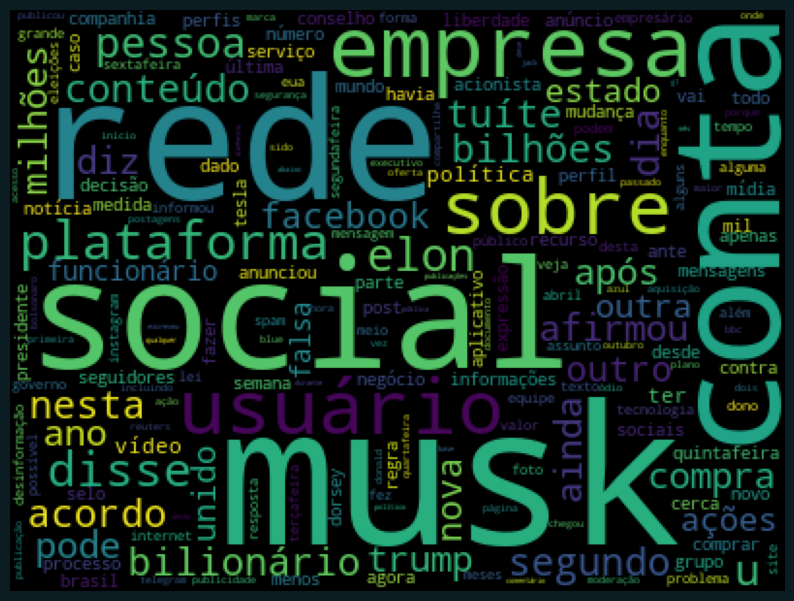

In [71]:
cloud = WordCloud(collocations=False,
                  max_font_size=100, 
                  width=400, 
                  height=300, 
                  background_color='black').generate(out)
figure(figsize=(10,8))
imshow(cloud)
axis('off')
show()